In [1]:

! pip install pandas numpy scikit-learn

In [2]:
pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from pennylane import numpy as pnp
import pennylane as qml
from pennylane.optimize import NesterovMomentumOptimizer

# Load the dataset
data = pd.read_csv('/content/climate_change.csv')

# Define the features (X) and the target variable (y)
X = data[['MEI', 'CO2', 'CH4', 'N2O', 'CFC-11', 'CFC-12', 'TSI', 'Aerosols', 'Year', 'Month']]
y = data['Temp']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a quantum device
n_qubits = X_train_scaled.shape[1]
dev = qml.device("default.qubit", wires=n_qubits)

# Define a quantum circuit (feature map) for embedding classical data
def quantum_circuit(params, x):
    qml.templates.AngleEmbedding(x, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(params, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(w)) for w in range(n_qubits)]

# Initialize random parameters for the quantum circuit
params = pnp.random.random((10, n_qubits, 3), requires_grad=True)  # Increased number of layers worked towards a better result.

# Create a QNode for PennyLane
@qml.qnode(dev)
def circuit(params, x):
    return quantum_circuit(params, x)

# Encode the training data using the quantum circuit
encoded_X_train = np.array([circuit(params, x) for x in X_train_scaled])
encoded_X_test = np.array([circuit(params, x) for x in X_test_scaled])

# Use a classical Support Vector Regressor (SVR) for regression
regressor = SVR(kernel="rbf")  # Changed to RBF kernel
regressor.fit(encoded_X_train, y_train)

# Make predictions on the test set
y_pred = regressor.predict(encoded_X_test)

# Calculate the Mean Squared Error (MSE) and R-squared (R^2) value
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 0.011553182234781096
R-squared: 0.6421644366393319


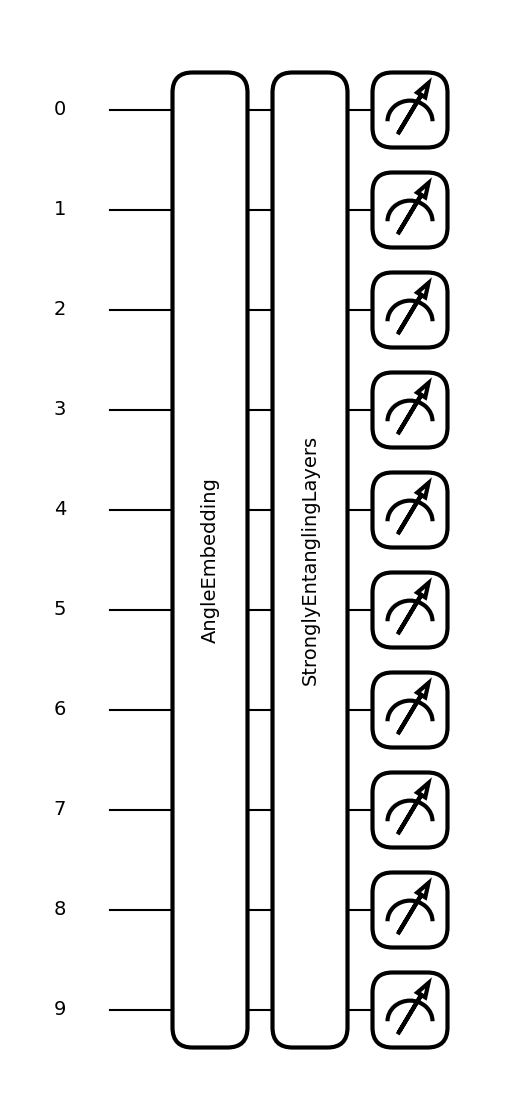

In [8]:
fig, ax = draw_mpl(circuit)(params, X_train_scaled[0])
fig.savefig("quantum_circuit.png", dpi=300)  # Save as a high-resolution PNG file


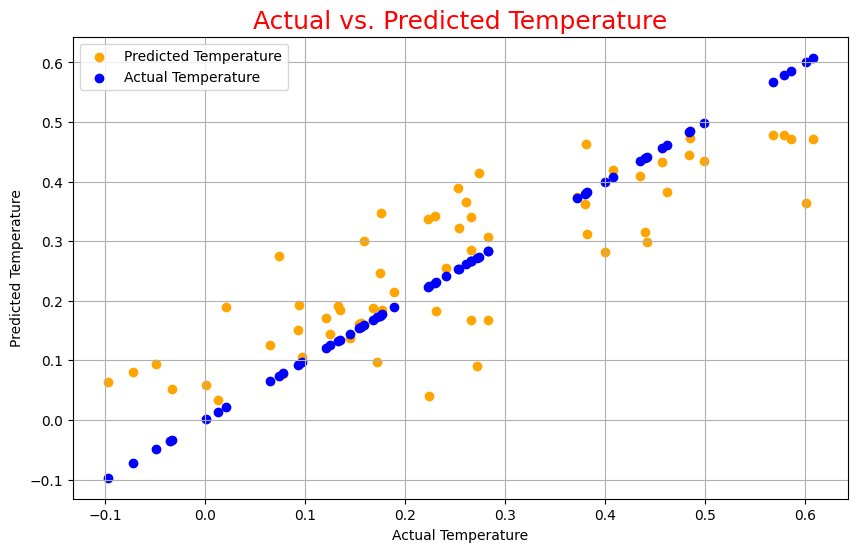

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot between actual and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='orange', label='Predicted Temperature')
plt.scatter(y_test, y_test, color='blue', label='Actual Temperature')
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.title('Actual vs. Predicted Temperature', fontsize=18, color='red')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


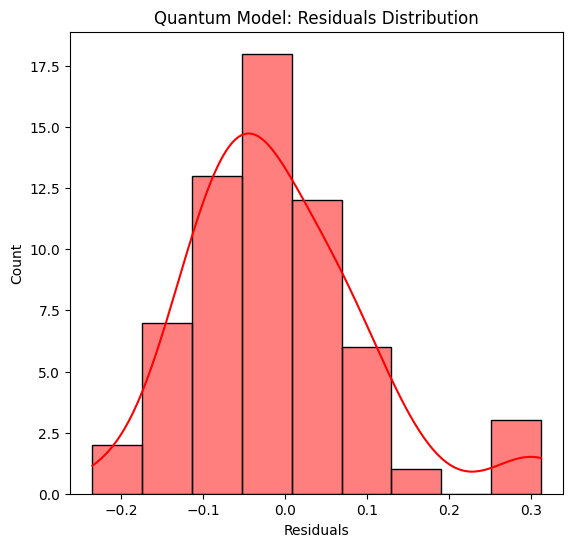

In [13]:
residuals_quantum = y_test - y_pred
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 2)
sns.histplot(residuals_quantum, kde=True, color='red')
plt.title('Quantum Model: Residuals Distribution')
plt.xlabel('Residuals')

plt.show()


